In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from models.nt_classifier import build as build_model
from config import *
from util.plot_utils import balance_df, obtain_plot, plot_logs, plot_roc_curves, collect_results_based_on_confidence_level
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
how = 'splash'

In [16]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', '1_20copy') #'binary_cl2')

In [17]:
MIN_N_READS = 3

if how == 'ricseq':
    
    import dataset.preprocessing as utils
    info = utils.read_dataframe(os.path.join(original_files_dir, 'index_bio_regions.Tx.RI_ALL.txt'), columns_to_drop = ['Unnamed: 0'])
    df = pd.read_csv(os.path.join(processed_files_dir, f'final_{how}_RANDOM_FULL.csv'))

    
    filename = os.path.join(original_files_dir, 'Tx.RI_ALL.specie.no_abundant.filter_rep.no_mirna.no_mito.no_cds_cds.bedpe')

    rows = []
    with open(filename)as f:
        for line in f:
            L = line.strip().split()
            rows.append(L)

    all_interactions = pd.DataFrame(rows, columns = ['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'name', 'n_reads', 'strand1', 'strand2', 'other_id', 'experiment'] )
    all_interactions['n_reads'] = all_interactions['n_reads'].apply(pd.to_numeric)
    all_interactions = all_interactions[all_interactions['experiment'] == 'hs_RIC-seq__HeLa_merge.InterGene.arms']
    all_interactions = all_interactions[all_interactions.n_reads>=MIN_N_READS]

    merged = all_interactions.merge(info, on = 'name')
    merged = merged[['ensembl_gene_id_1', 'ensembl_gene_id_2', 'x1', 'x2', 'y1', 'y2']].rename({'ensembl_gene_id_1':'gene_id1', 'ensembl_gene_id_2':'gene_id2'}, axis = 1)
    merged[['couples', 'need_to_swap']] = merged[['gene_id1', 'gene_id2']].apply(utils.create_pairs, axis = 1)

    def swap_genes_if_needed(df):
        original_dim = df.shape[0]
        where = df.need_to_swap
        df.loc[where, ['gene_id1', 'gene_id2']] = (df.loc[where, ['gene_id2', 'gene_id1']].values)
        df.loc[where, ['x1', 'y1']] = (df.loc[where, ['y1', 'x1']].values)
        df.loc[where, ['x2', 'y2']] = (df.loc[where, ['y2', 'x2']].values)
        df = df.drop('need_to_swap', axis = 1)
        df = df.drop_duplicates().reset_index(drop = True)
        n_duplicates = original_dim - df.shape[0] 
        return df

    merged = swap_genes_if_needed(merged)
    merged[['x1', 'x2', 'y1', 'y2']] = merged[['x1', 'x2', 'y1', 'y2']].apply(pd.to_numeric)
    hq_test = test500.copy()

    regex1 = hq_test.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()
    regex2 = hq_test.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()
    hq_test['g1g2_id'] = regex1[0] + '_' + regex2[0]
    hq_test['x1_window'] = regex1[1]
    hq_test['y1_window'] = regex2[1]
    hq_test[['x1_window', 'y1_window']] = hq_test[['x1_window', 'y1_window']].apply(pd.to_numeric)
    
    hq_test['real_seed_x1'] = hq_test['x1_window'] + hq_test['seed_x1']
    hq_test['real_seed_x2'] = hq_test['x1_window'] + hq_test['seed_x2']
    hq_test['real_seed_y1'] = hq_test['y1_window'] + hq_test['seed_y1']
    hq_test['real_seed_y2'] = hq_test['y1_window'] + hq_test['seed_y2']

    hq_test = hq_test[['couples', 'g1g2_id', 'real_seed_x1', 'real_seed_x2', 'real_seed_y1', 'real_seed_y2']].rename(
        {'couples':'real_id_couple', 'g1g2_id': 'couples', 'real_seed_x1':'x1', 'real_seed_x2':'x2', 
         'real_seed_y1':'y1', 'real_seed_y2':'y2'}, axis = 1)
    final_merge = hq_test.merge(merged, on = ['couples', 'x1', 'x2', 'y1', 'y2'])
    real_hq = set(final_merge.real_id_couple)
    real_hq_couples = set(final_merge.couples)
    
    res = pd.read_csv(os.path.join(checkpoint_dir, f'{how}_results.csv'))
    res_pos, res_neg = res[res.ground_truth == 1], res[res.ground_truth == 0] 


    df_pairs_full = pd.read_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM_RICSEQ.csv'))
    sampled_negatives = set(df_pairs_full[df_pairs_full.positive.isin(real_hq_couples)].negative)
    res_neg = res_neg[res_neg.couples.isin(sampled_negatives)|res_neg.couples.isin(real_hq_couples)]

    res = pd.concat([res_pos[res_pos.id_sample.isin(real_hq)], res_neg], axis = 0)

    print(f'{res_pos.shape[0] - res_pos[res_pos.id_sample.isin(real_hq)].shape[0]} couples are excluded because they are not supported by enough reads')
    print(f'The actual # of positives is {res_pos[res_pos.id_sample.isin(real_hq)].shape[0]}')
    print(f'The actual # of unique pairs is {len(res_pos[res_pos.id_sample.isin(real_hq)].couples.unique())}')
    print('\n\n METRICS:')
    print(classification_report(res.ground_truth, res.prediction))
    
elif how in ['mario', 'splash']:
    res = pd.read_csv(os.path.join(checkpoint_dir, f'{how}_results.csv'))
    print('METRICS:')
    print(classification_report(res.ground_truth, res.prediction))

METRICS:
              precision    recall  f1-score   support

           0       0.68      0.24      0.35      1079
           1       0.39      0.82      0.53       650

    accuracy                           0.45      1729
   macro avg       0.54      0.53      0.44      1729
weighted avg       0.57      0.45      0.42      1729



## Metrics

In [49]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

1    1355
0     374
Name: prediction, dtype: int64


0    1079
1     650
Name: ground_truth, dtype: int64


In [50]:
n_conf = 10

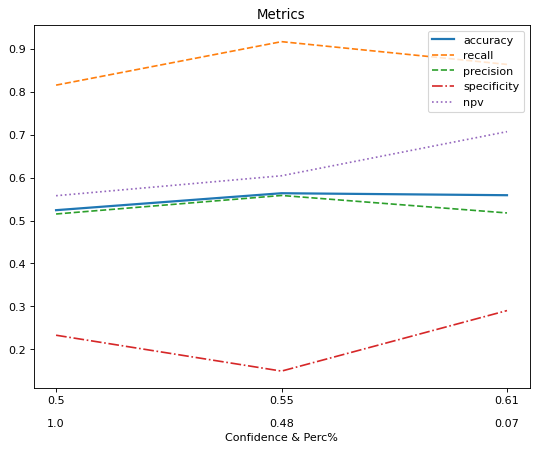

In [51]:
obtain_plot(balance_df(res), n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)

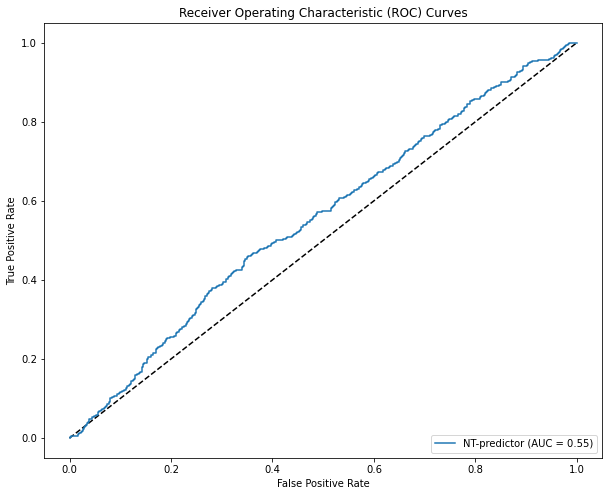

In [52]:
plot_roc_curves([{'prob': res.probability, 'model_name': 'NT-predictor'}], res.ground_truth)

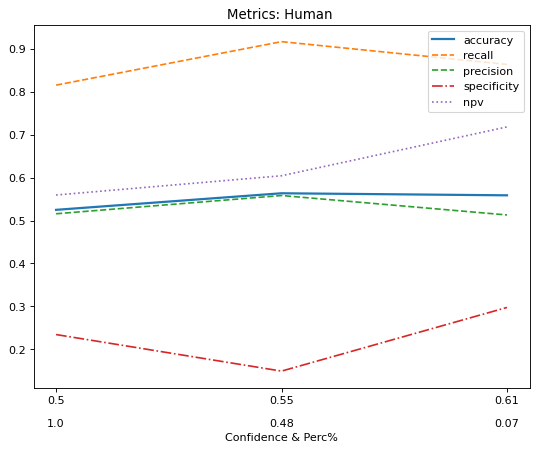

In [53]:
human = res[(res.specie == 'human')]
obtain_plot(balance_df(human), n_original_df = res.shape[0], title = f'Metrics: Human ', n_conf = n_conf)

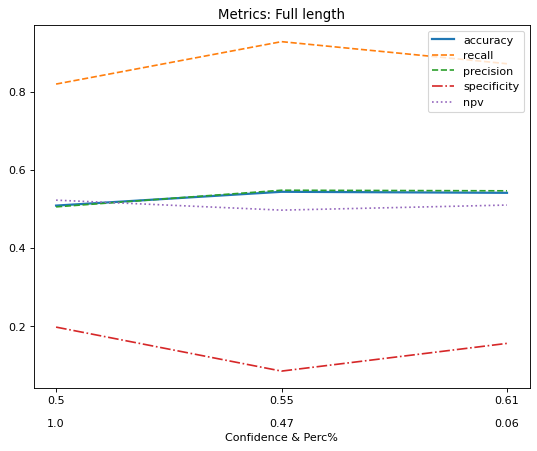

In [54]:
full_length = res[(res.original_length1 <= MAX_RNA_SIZE)&(res.original_length2 <= MAX_RNA_SIZE)]
obtain_plot(balance_df(full_length), n_original_df = res.shape[0], title = f'Metrics: Full length', n_conf = 10)

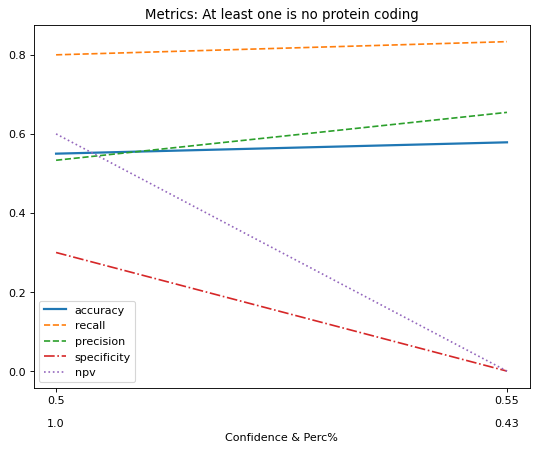

In [55]:
no_pc = res[(res['gene1_pc'] == False)|(res['gene2_pc'] == False)]

obtain_plot(balance_df(no_pc), n_original_df = res.shape[0], title = f'Metrics: At least one is no protein coding', n_conf = n_conf)

0.5214461538461539


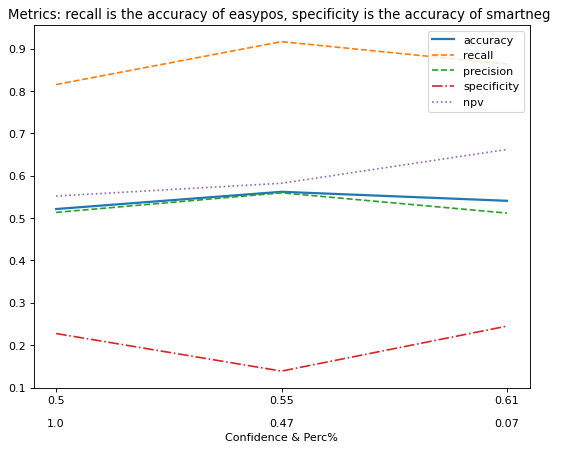

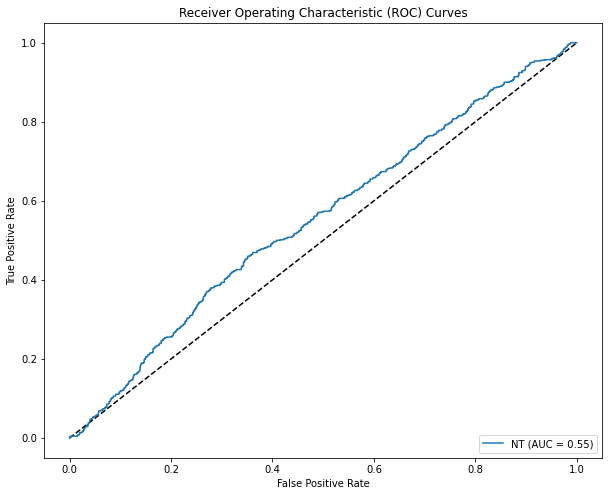

In [56]:
easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])]
balanced_epsn = balance_df(easypos_smartneg)

print(balanced_epsn[balanced_epsn.ground_truth == balanced_epsn.prediction].shape[0]/balanced_epsn.shape[0])

obtain_plot(balanced_epsn, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg ', n_conf = n_conf)
plot_roc_curves([{'prob': balanced_epsn.probability, 'model_name': 'NT'},
                ], balanced_epsn.ground_truth)

0.3333333333333333


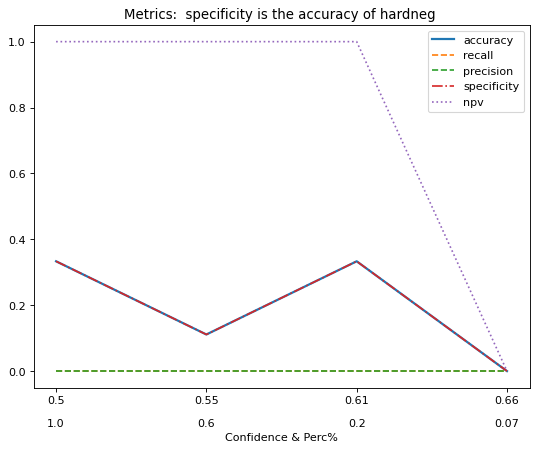

In [57]:
hn = res[(res.policy == 'hardneg')]
print(hn[hn.ground_truth == hn.prediction].shape[0]/hn.shape[0])

obtain_plot(hn, n_original_df = res.shape[0], title = f'Metrics:  specificity is the accuracy of hardneg ', n_conf = n_conf)

0.5217391304347826


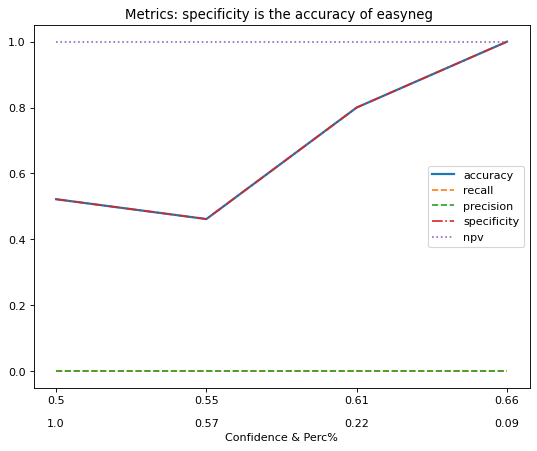

In [58]:
easy = res[(res.policy == 'easyneg')]
print(easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0])

obtain_plot(easy, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg ', n_conf = n_conf)

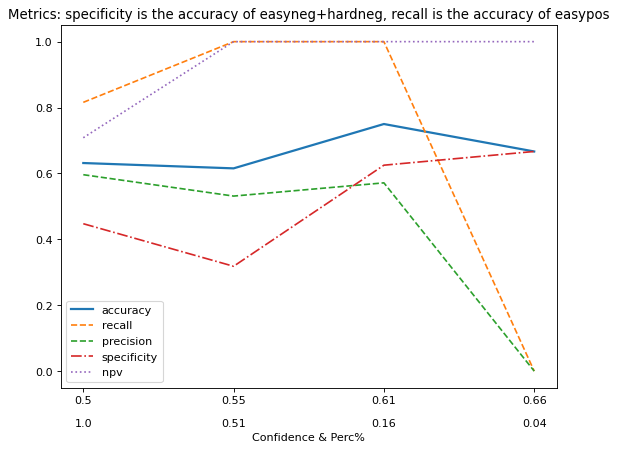

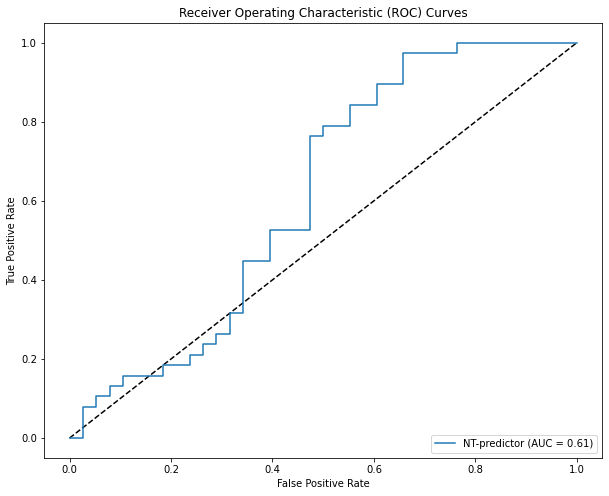

In [59]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

vc = ephnen.ground_truth.value_counts()
assert vc.loc[1] > vc.loc[0]
n_to_exclude = vc.loc[1] - vc.loc[0]
ephnen_gt = ephnen[ephnen.ground_truth==1]
id_to_exclude = list(ephnen_gt.sample(frac = 1).head(n_to_exclude).id_sample)
ephnen_sampled = ephnen[~ephnen.id_sample.isin(id_to_exclude)]

obtain_plot(ephnen_sampled, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg+hardneg, recall is the accuracy of easypos', n_conf = n_conf)
plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT-predictor'}], ephnen_sampled.ground_truth)

# XAI

In [33]:
xai = pd.read_csv(os.path.join(checkpoint_dir, 'gradcam_results_splash.csv'))

In [34]:
gradcam_results = xai[xai.probability>0.5]

#### Subset XAI results

euclidean: 0.6167
euclidean_rand: 0.7196


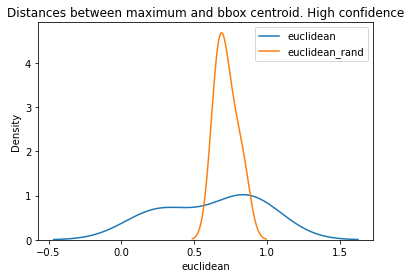

In [44]:
n_best = 5

gradcam_results = xai.sort_values('probability').tail(n_best)
#gradcam_results = xai.sort_values('iou_value').tail(n_best)
#gradcam_results = xai[(xai.probability>0.6)&(xai.probability<0.77)].sample(n_best)

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. High confidence')
plt.legend()
plt.show()